# Directional Filtered Complex Statistics with Data Augmentatio Descriptor — DUD-E Dataset

This notebook computes **rotationally invariant topological descriptors** using **Vietoris–Rips (VR) complexes** for 3D molecular point clouds.

It extends persistent homology–based molecular fingerprints by:
1. Computing **H₀ + H₁** persistence diagrams from atomic coordinates  
2. Extracting **statistical summaries** from each diagram  
3. Optionally applying **rotational augmentation** to test descriptor invariance  
4. Training machine learning models for ligand–decoy classification  
5. Evaluating with **ROC–AUC** and **Enrichment Factor (EF%)**

VR persistence complements directional and anisotropic PH descriptors by capturing **pure topology** independent of molecule orientation.


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from ripser import ripser
from scipy.stats import iqr
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy.spatial.transform import Rotation as R  
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

# Define the path to the extracted directory
targets_dir = r'C:\Users\kanis\Desktop\Python\Computational Geometry and Topology for Drug Discovery\DUD-E\DUDE_diverse_pointClouds\DUDE_diverse_pointClouds'

# List and sort the contents (targets)
targets = sorted(os.listdir(targets_dir))
print("Targets found:", targets)

Targets found: ['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']


## 1. Dataset Loading and Structure

We use the **DUD-E (Directory of Useful Decoys, Enhanced)** dataset.

Each target directory (e.g. `akt1/`) contains:
- `ligs/` — active molecules (ligands)
- `decoys/` — structurally similar but inactive molecules

We first verify the number of ligands and decoys available for analysis.

In [3]:
# Define paths to ligand and decoy folders
ligands_path = os.path.join(targets_dir, "akt1", "ligs")
decoys_path = os.path.join(targets_dir, "akt1", "decoys")

# List files
ligands_1 = os.listdir(ligands_path)
decoys_1 = os.listdir(decoys_path)

# Print counts
print(f"Number of ligand files: {len(ligands_1)}")
print(f"Number of decoy files: {len(decoys_1)}")


Number of ligand files: 293
Number of decoy files: 16444


## 2. Directional Basis Setup

Although VR persistence is rotation invariant, we define **fixed 3D unit directions** (x, y, z) to project and sample structures along orthogonal axes.
These serve as reference directions for testing rotational stability.

In [4]:
def normalize(dirs):
    return dirs / np.linalg.norm(dirs, axis=1, keepdims=True)


## 3. Persistence Statistics Extraction

We summarize persistence diagrams into **38 numerical features** using birth, death, midpoint, and lifetime distributions.

For each, we compute:
- mean, std, median, IQR, range  
- 10%, 25%, 75%, 90% quantiles  
- count and Shannon entropy  

The function `persistence_statistics()` ensures fixed-length feature vectors.

In [5]:
def generate_unit_directions(n=30, seed=42):
    np.random.seed(seed)
    dirs = np.random.randn(n, 3)
    return normalize(dirs)

def persistence_statistics(diagram):
    if len(diagram) == 0:
        return np.zeros(38)
    births = diagram[:, 0]
    deaths = diagram[:, 1]
    mids = (births + deaths) / 2
    lives = deaths - births

    def stats(x):
        return [
            np.mean(x), np.std(x), np.median(x), iqr(x), np.ptp(x),
            *np.percentile(x, [10, 25, 75, 90])
        ]

    L = np.sum(lives)
    prob = lives / (L + 1e-12)
    entropy = -np.sum(prob * np.log(prob + 1e-12))
    vec = stats(births) + stats(deaths) + stats(mids) + stats(lives) + [len(lives), entropy]
    return np.nan_to_num(vec, nan=0.0, posinf=0.0, neginf=0.0)


## 4. Directional Persistence Statistics

The `directional_persistence_stats()` function:
- Projects atomic coordinates along each unit direction  
- Computes PH statistics at several threshold levels  
- Extracts **H₀ (components)** and **H₁ (holes)** features  
- Concatenates them into a single descriptor vector

This encodes molecular topology along fixed orientations.


In [6]:
def directional_persistence_stats(atom_positions, r=1.7, directions=30, thresholds=5):
    dirs = generate_unit_directions(directions)
    all_vecs = []

    for v in dirs:
        heights = atom_positions @ v.T
        for threshold in np.linspace(np.min(heights), np.max(heights), thresholds):
            idx = np.where(heights <= threshold)[0]
            if len(idx) < 2:
                continue
            cloud = atom_positions[idx]
            result = ripser(cloud, maxdim=0, thresh=r)
            diag = result['dgms'][0]
            vec = persistence_statistics(diag)
            all_vecs.append(vec)

    if not all_vecs:
        return np.zeros(38 * directions * thresholds)
    return np.concatenate(all_vecs)


In [7]:
def generate_rotated_point_clouds(atom_positions, n_rotations=5, seed=42):
    np.random.seed(seed)
    rotated_clouds = [atom_positions]  
    for _ in range(n_rotations):
        rot = R.random().as_matrix()  # 3x3 rotation matrix
        rotated = atom_positions @ rot.T
        rotated_clouds.append(rotated)
    return rotated_clouds

## 5. Feature Extraction for DUD-E Molecules

Each molecule’s 3D coordinates are converted into topological descriptors.

Steps:
1. Load atomic coordinates from `.csv`
2. Compute PH descriptors
3. Pad feature vectors for uniform length
4. Label ligands = 1, decoys = 0

In [8]:
def extract_features_directional_augmented(file_list, directory, label, r=1.7, directions=None, thresholds=5, n_rotations=5):
    data = []
    max_len = 0
    
    for file in file_list:
        try:
            df = pd.read_csv(os.path.join(directory, file), header=None)
            atom_positions = df.iloc[:, :3].values
            if atom_positions.shape[0] < 2:
                continue
            
            # Generate rotated versions of the point cloud
            rotated_clouds = generate_rotated_point_clouds(atom_positions, n_rotations)
            
            # Extract features for each rotated version
            for rotated in rotated_clouds:
                feat_vec = directional_persistence_stats(rotated, r, directions, thresholds)
                max_len = max(max_len, len(feat_vec))
                data.append((feat_vec, label))
                
        except Exception as e:
            print(f"Error in {file}: {e}")
            continue
    
    # Pad all feature vectors to same length
    rows = []
    for feat_vec, lbl in data:
        if len(feat_vec) < max_len:
            feat_vec = np.pad(feat_vec, (0, max_len - len(feat_vec)), 'constant')
        rows.append(list(feat_vec) + [lbl])
    
    if not rows:
        return pd.DataFrame()
    
    columns = [f'dps_{i+1}' for i in range(max_len)] + ['label']
    return pd.DataFrame(rows, columns=columns)

In [9]:
def extract_features_directional(file_list, directory, label, r=1.7, directions=None, thresholds=5):
    data = []
    max_len = 0

    for file in file_list:
        try:
            df = pd.read_csv(os.path.join(directory, file), header=None)
            atom_positions = df.iloc[:, :3].values
            if atom_positions.shape[0] < 2:
                continue
            feat_vec = directional_persistence_stats(atom_positions, r, directions, thresholds)
            max_len = max(max_len, len(feat_vec))
            data.append((feat_vec, label))
        except Exception as e:
            print(f"Error in {file}: {e}")
            continue

    rows = []
    for feat_vec, lbl in data:
        if len(feat_vec) < max_len:
            feat_vec = np.pad(feat_vec, (0, max_len - len(feat_vec)), 'constant')
        rows.append(list(feat_vec) + [lbl])

    if not rows:
        return pd.DataFrame()

    columns = [f'dps_{i+1}' for i in range(max_len)] + ['label']
    return pd.DataFrame(rows, columns=columns)

## 6. Enrichment Factor Metric

The **Enrichment Factor (EF%)** measures early retrieval of active compounds.

It compares the top-ranked predictions against random selection, quantifying how well the model identifies ligands at early cutoffs.

In [10]:
def enrichment_factor(y_true, y_probs, top_percent=1):
    N = len(y_true)
    top_n = int(N * (top_percent / 100))
    sorted_idx = np.argsort(y_probs)[::-1][:top_n]
    hits = np.sum(np.array(y_true)[sorted_idx])
    total_actives = np.sum(y_true)
    ef = (hits / top_n) / (total_actives / N)
    return ef

## 7. Model Training Pipeline — Per Target

The function `run_pipeline_for_target()`:
- Loads ligands and decoys for a protein
- Extracts PH-based features
- Balances training sets
- Scales features
- Trains multiple ML models:
  - Logistic Regression  
  - Random Forest  
  - SVM (RBF Kernel)  
  - XGBoost  
- Computes ROC–AUC and EF%

It also plots ROC curves to visualize discriminability.

In [11]:
def run_pipeline_for_target(target_path, r=1.7, directions=30, thresholds=5, augment=False, n_augmentations=5):
    lig_dir = os.path.join(target_path, 'ligs')
    decoy_dir = os.path.join(target_path, 'decoys')
    lig_files = os.listdir(lig_dir)
    decoy_files = os.listdir(decoy_dir)

    # Split into train and test sets (20% test)
    train_lig, test_lig = train_test_split(lig_files, test_size=0.2, random_state=42)
    train_dec, test_dec = train_test_split(decoy_files, test_size=0.2, random_state=42)

    # Downsample decoys to match number of ligands
    train_dec = resample(train_dec, replace=False, n_samples=len(train_lig), random_state=42)
    test_dec = resample(test_dec, replace=False, n_samples=len(test_lig), random_state=42)

    # Feature extraction with augmentation
    if augment:
        train_lig_df = extract_features_directional_augmented(
            train_lig, lig_dir, label=1, r=r, directions=directions, thresholds=thresholds, n_rotations=n_augmentations
        )
    else:
        train_lig_df = extract_features_directional(
            train_lig, lig_dir, label=1, r=r, directions=directions, thresholds=thresholds
        )

    train_dec_df = extract_features_directional(
        train_dec, decoy_dir, label=0, r=r, directions=directions, thresholds=thresholds
    )
    test_lig_df = extract_features_directional(
        test_lig, lig_dir, label=1, r=r, directions=directions, thresholds=thresholds
    )
    test_dec_df = extract_features_directional(
        test_dec, decoy_dir, label=0, r=r, directions=directions, thresholds=thresholds
    )

    # Combine and shuffle datasets
    train_df = pd.concat([train_lig_df, train_dec_df]).sample(frac=1, random_state=42)
    test_df = pd.concat([test_lig_df, test_dec_df]).sample(frac=1, random_state=42)

    # Separate features and labels
    X_train = train_df.drop("label", axis=1)
    y_train = train_df["label"]
    X_test = test_df.drop("label", axis=1)
    y_test = test_df["label"]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM (RBF Kernel)": SVC(probability=True),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    model_results = []
    plt.figure(figsize=(6, 5))

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        probs = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, probs)
        ef = enrichment_factor(y_test, probs, top_percent=15)
        fpr, tpr, _ = roc_curve(y_test, probs)

        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")

        model_results.append({
            'Target': os.path.basename(target_path),
            'Model': model_name,
            'AUC': round(auc, 4),
            'EF%': round(ef, 3)
        })

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title(f"{os.path.basename(target_path)} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(model_results)


## 8. Running All DUD-E Targets

We iterate over all protein targets, computing and aggregating model results for each.
This produces a summary of AUC and EF% across the dataset.


Processing target: akt1


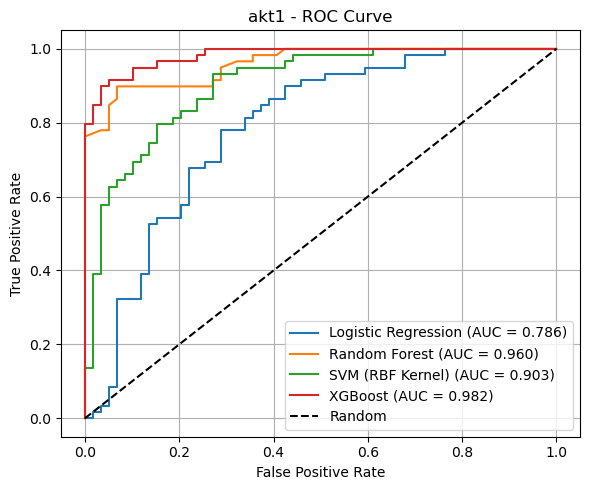


Processing target: ampc


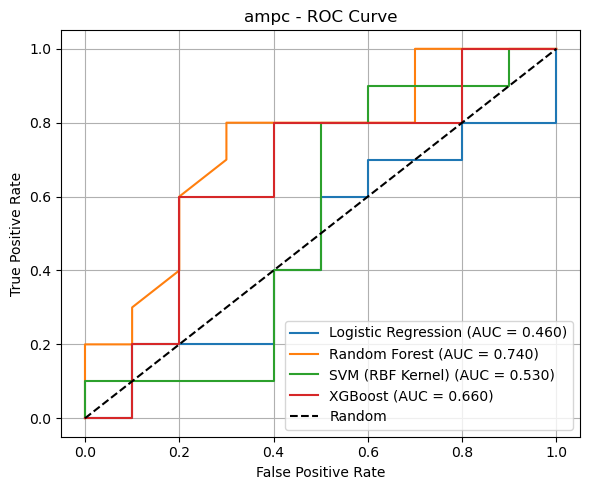


Processing target: cp3a4


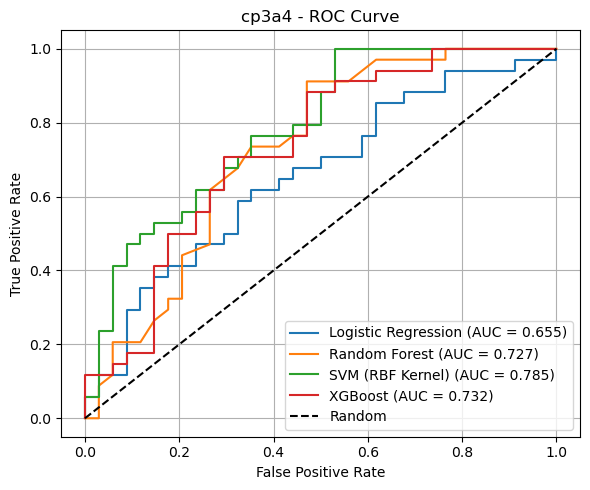


Processing target: cxcr4


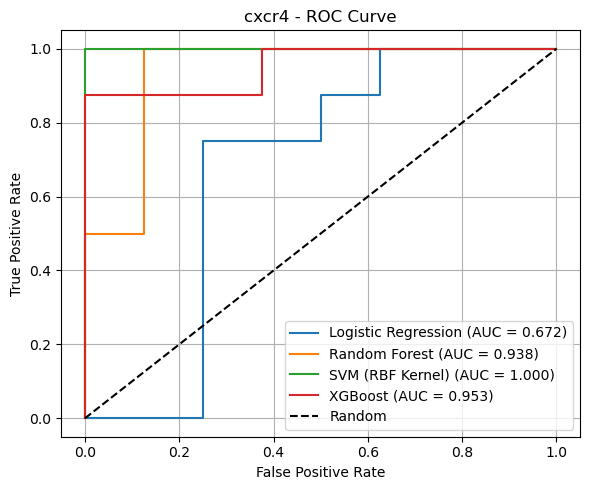


Processing target: gcr


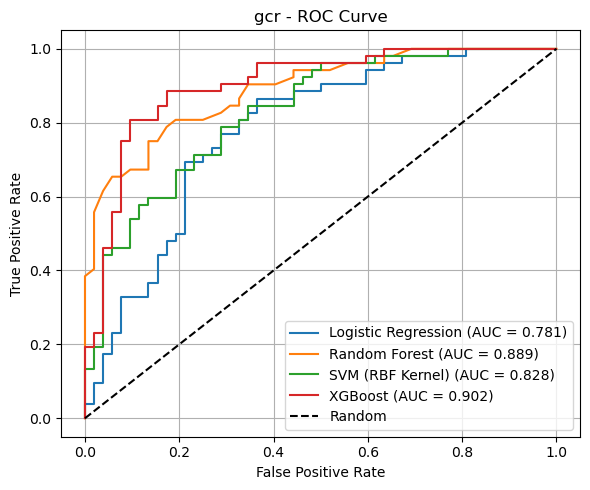


Processing target: hivpr


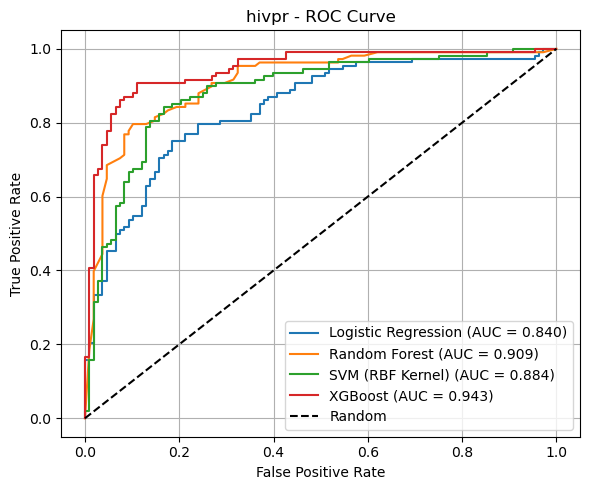


Processing target: hivrt


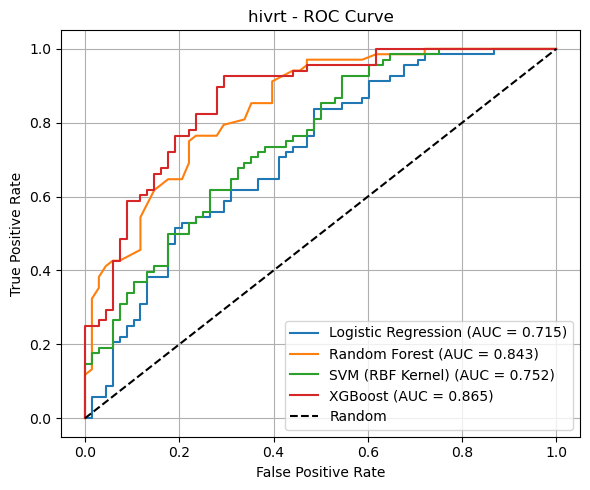


Processing target: kif11


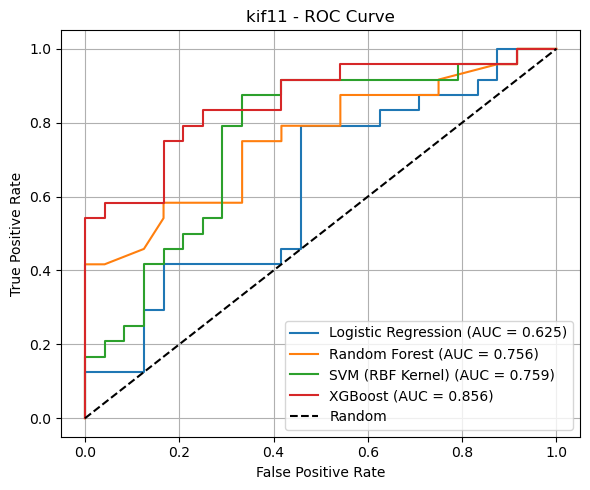

In [12]:
all_results = []

base_path = "DUDE_diverse_pointClouds/DUDE_diverse_pointClouds"
targets = sorted(os.listdir(base_path))

for target in targets:
    print(f"\nProcessing target: {target}")
    target_path = os.path.join(base_path, target)
    try:
        # NEW: Enable augmentation here for training
        target_results = run_pipeline_for_target(target_path, r=1.7, directions=10, thresholds=3, augment=True)
        target_results["Target"] = target
        all_results.append(target_results)
    except Exception as e:
        print(f"Error processing {target}: {e}") 

In [13]:
# Combine all results into one DataFrame
if all_results:  # Only proceed if we have results
    final_results_df = pd.concat(all_results, ignore_index=True)
    
    # Select and reorder columns
    final_results_df = final_results_df[["Target", "Model", "AUC", "EF%"]]
    
    # Print and save results
    print("\nFinal Results:")
    print(final_results_df)
    


Final Results:
   Target                Model     AUC    EF%
0    akt1  Logistic Regression  0.7863  1.529
1    akt1        Random Forest  0.9604  2.000
2    akt1     SVM (RBF Kernel)  0.9029  1.882
3    akt1              XGBoost  0.9822  2.000
4    ampc  Logistic Regression  0.4600  1.333
5    ampc        Random Forest  0.7400  1.333
6    ampc     SVM (RBF Kernel)  0.5300  0.667
7    ampc              XGBoost  0.6600  1.333
8   cp3a4  Logistic Regression  0.6548  1.400
9   cp3a4        Random Forest  0.7271  1.400
10  cp3a4     SVM (RBF Kernel)  0.7846  1.600
11  cp3a4              XGBoost  0.7318  1.200
12  cxcr4  Logistic Regression  0.6719  0.000
13  cxcr4        Random Forest  0.9375  2.000
14  cxcr4     SVM (RBF Kernel)  1.0000  2.000
15  cxcr4              XGBoost  0.9531  2.000
16    gcr  Logistic Regression  0.7811  1.600
17    gcr        Random Forest  0.8892  2.000
18    gcr     SVM (RBF Kernel)  0.8284  1.733
19    gcr              XGBoost  0.9020  1.733
20  hivpr  Logisti


Processing (VR) target: akt1


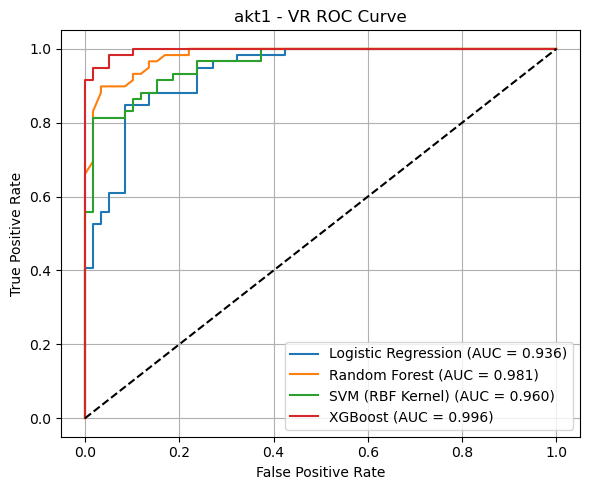

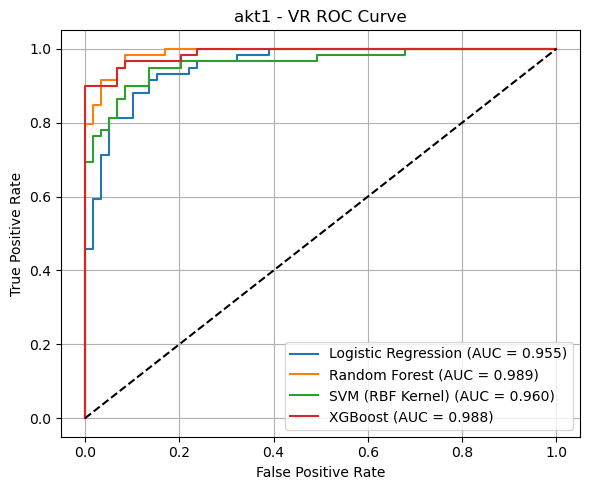


Processing (VR) target: ampc


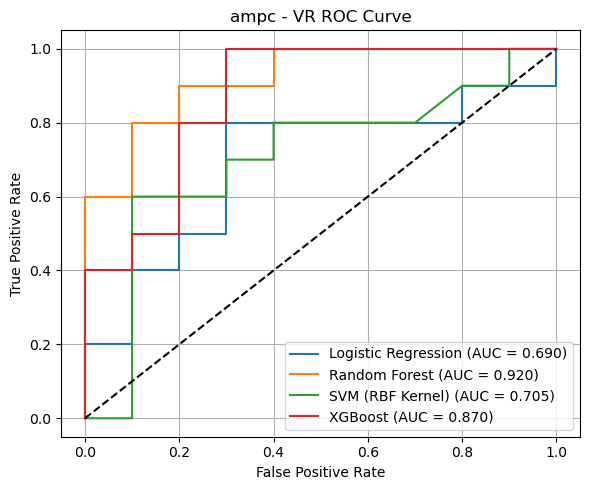

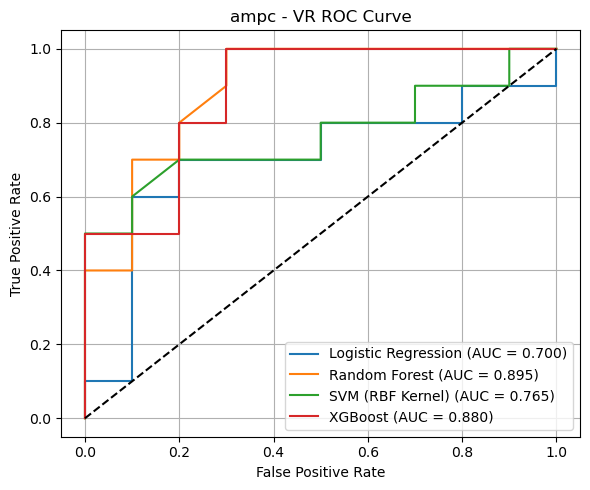


Processing (VR) target: cp3a4


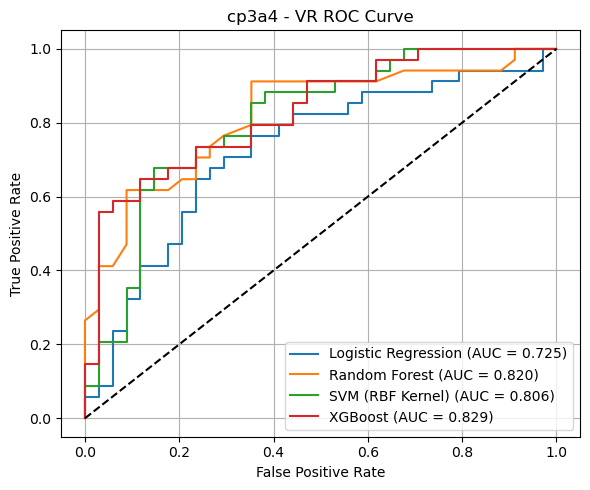

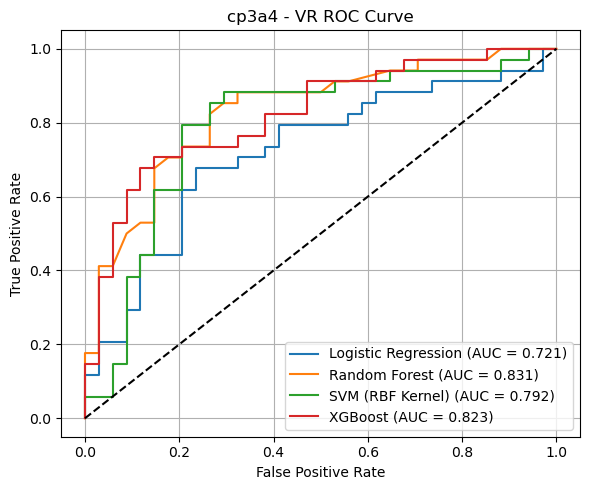


Processing (VR) target: cxcr4


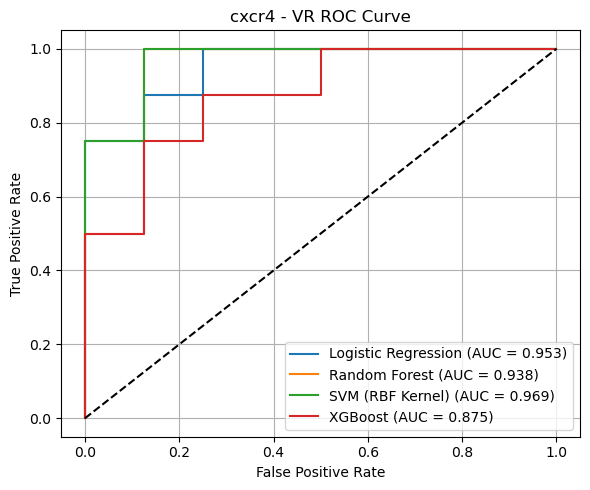

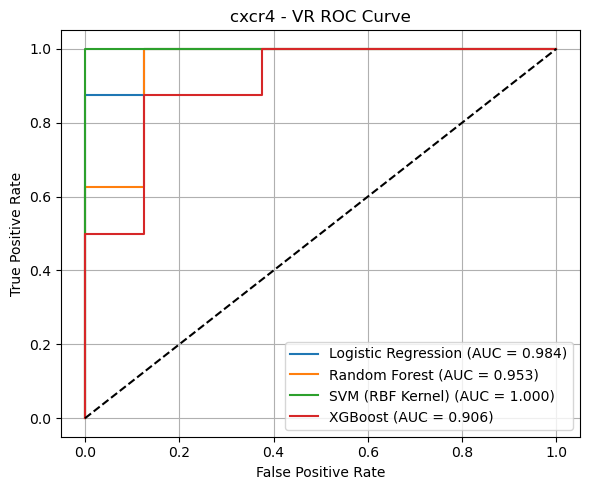


Processing (VR) target: gcr


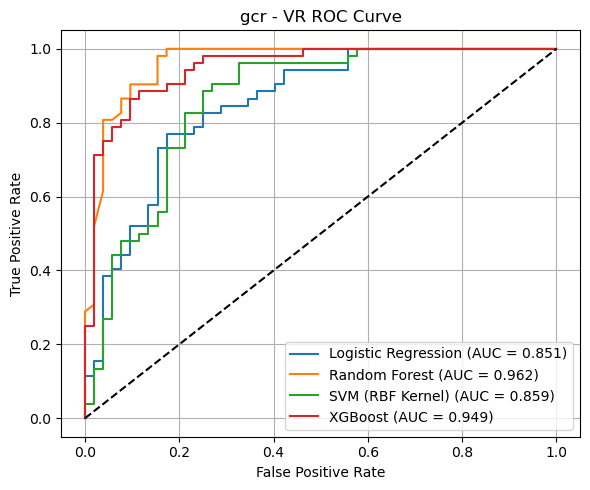

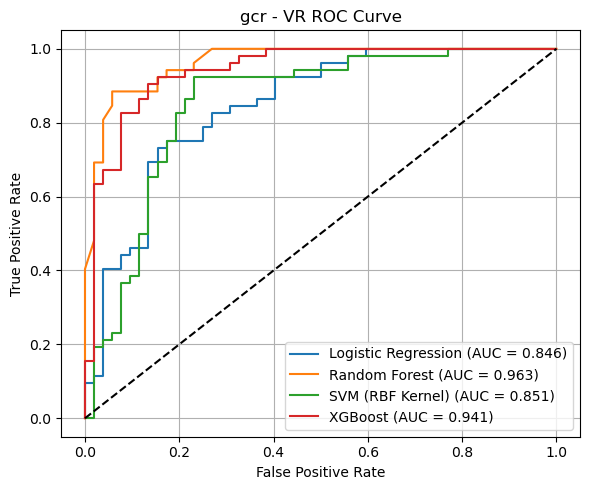


Processing (VR) target: hivpr


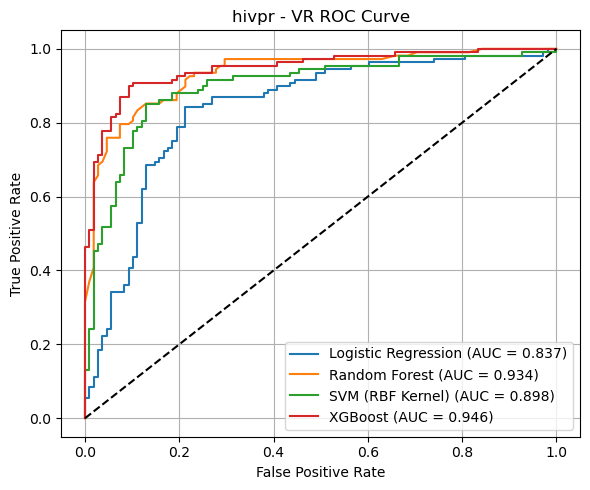

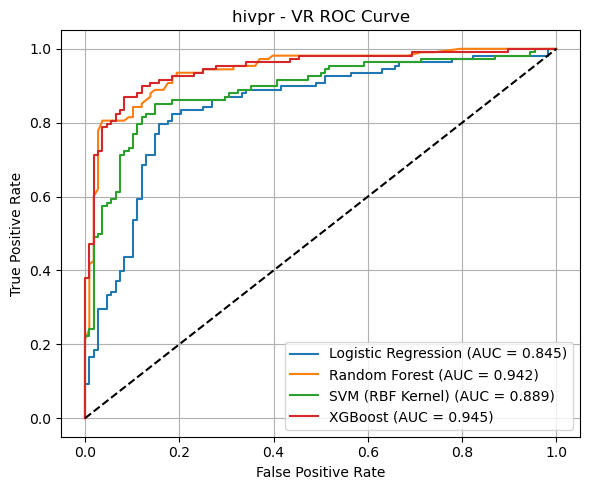


Processing (VR) target: hivrt


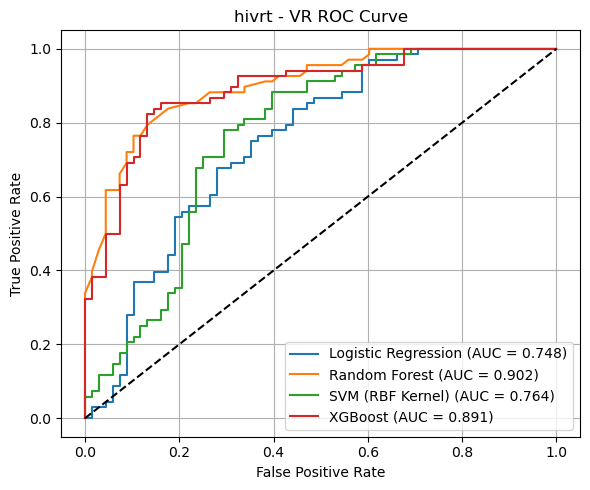

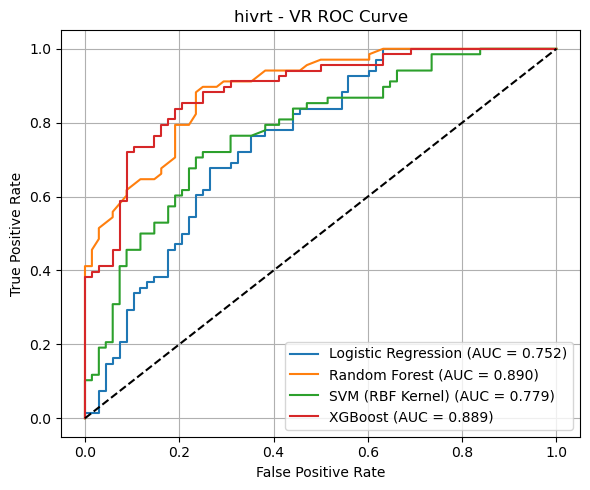


Processing (VR) target: kif11


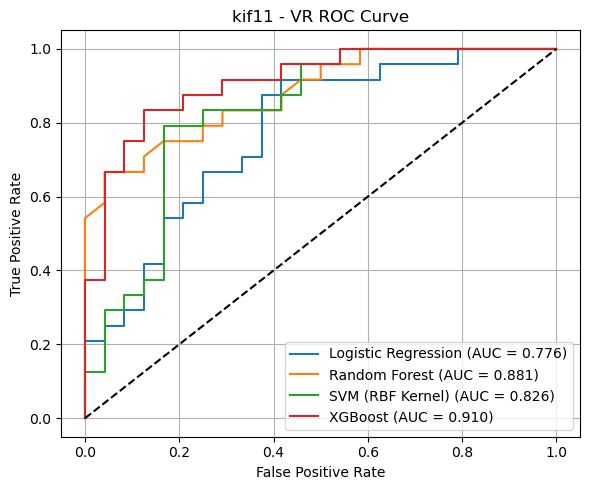

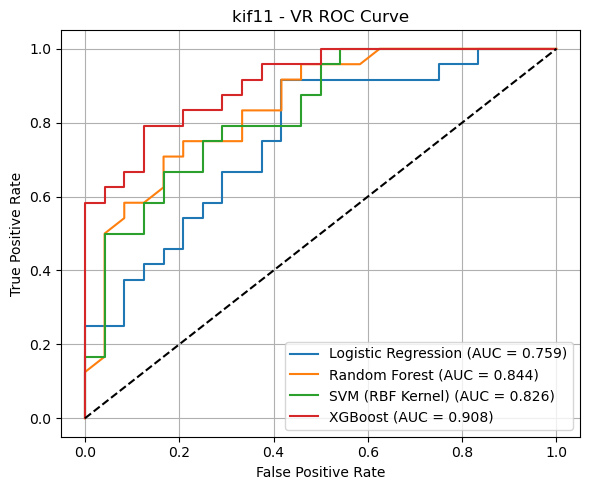

   Target                Model     AUC Augmentation
0    akt1  Logistic Regression  0.9362          Yes
1    akt1        Random Forest  0.9813          Yes
2    akt1     SVM (RBF Kernel)  0.9598          Yes
3    akt1              XGBoost  0.9960          Yes
4    akt1  Logistic Regression  0.9546           No
..    ...                  ...     ...          ...
59  kif11              XGBoost  0.9097          Yes
60  kif11  Logistic Regression  0.7587           No
61  kif11        Random Forest  0.8438           No
62  kif11     SVM (RBF Kernel)  0.8264           No
63  kif11              XGBoost  0.9080           No

[64 rows x 4 columns]


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from ripser import ripser
from scipy.stats import iqr
from scipy.spatial.transform import Rotation as R

# Vietoris-Rips persistence statistics
def persistence_statistics(diagram):
    if len(diagram) == 0:
        return np.zeros(38)
    births = diagram[:, 0]
    deaths = diagram[:, 1]
    mids = (births + deaths) / 2
    lives = deaths - births

    def stats(x):
        return [
            np.mean(x), np.std(x), np.median(x), iqr(x), np.ptp(x),
            *np.percentile(x, [10, 25, 75, 90])
        ]

    L = np.sum(lives)
    prob = lives / (L + 1e-12)
    entropy = -np.sum(prob * np.log(prob + 1e-12))
    vec = stats(births) + stats(deaths) + stats(mids) + stats(lives) + [len(lives), entropy]
    return np.nan_to_num(vec, nan=0.0, posinf=0.0, neginf=0.0)

def vietoris_rips_stats(atom_positions, r=1.7):
    result = ripser(atom_positions, maxdim=1, thresh=r)  # compute up to H1
    all_vecs = []
    for diag in result['dgms']:
        vec = persistence_statistics(diag)
        all_vecs.append(vec)
    return np.concatenate(all_vecs)


# Rotations for augmentation (even though VR is rotation-invariant)
def generate_rotated_point_clouds(atom_positions, n_rotations=5, seed=42):
    np.random.seed(seed)
    rotated_clouds = [atom_positions]  # include original
    for _ in range(n_rotations):
        rot = R.random().as_matrix()
        rotated = atom_positions @ rot.T
        rotated_clouds.append(rotated)
    return rotated_clouds

# Feature extraction (VR)
def extract_features_vr(file_list, directory, label, r=1.7, augment=False, n_rotations=5):
    data = []
    max_len = 0

    for file in file_list:
        try:
            df = pd.read_csv(os.path.join(directory, file), header=None)
            atom_positions = df.iloc[:, :3].values
            if atom_positions.shape[0] < 2:
                continue

            if augment:
                clouds = generate_rotated_point_clouds(atom_positions, n_rotations)
            else:
                clouds = [atom_positions]

            for cloud in clouds:
                feat_vec = vietoris_rips_stats(cloud, r)
                max_len = max(max_len, len(feat_vec))
                data.append((feat_vec, label))

        except Exception as e:
            print(f"Error in {file}: {e}")
            continue

    # Pad feature vectors
    rows = []
    for feat_vec, lbl in data:
        if len(feat_vec) < max_len:
            feat_vec = np.pad(feat_vec, (0, max_len - len(feat_vec)), 'constant')
        rows.append(list(feat_vec) + [lbl])

    if not rows:
        return pd.DataFrame()

    columns = [f'vr_{i+1}' for i in range(max_len)] + ['label']
    return pd.DataFrame(rows, columns=columns)


# Training pipeline (VR)
def run_pipeline_vr(target_path, r=1.7, augment=False, n_augmentations=5):
    lig_dir = os.path.join(target_path, 'ligs')
    decoy_dir = os.path.join(target_path, 'decoys')
    lig_files = os.listdir(lig_dir)
    decoy_files = os.listdir(decoy_dir)

    # train-test split
    train_lig, test_lig = train_test_split(lig_files, test_size=0.2, random_state=42)
    train_dec, test_dec = train_test_split(decoy_files, test_size=0.2, random_state=42)

    # balance decoys with ligands
    train_dec = resample(train_dec, replace=False, n_samples=len(train_lig), random_state=42)
    test_dec = resample(test_dec, replace=False, n_samples=len(test_lig), random_state=42)

    # extract features
    train_lig_df = extract_features_vr(train_lig, lig_dir, label=1, r=r, augment=augment, n_rotations=n_augmentations)
    train_dec_df = extract_features_vr(train_dec, decoy_dir, label=0, r=r, augment=False)
    test_lig_df = extract_features_vr(test_lig, lig_dir, label=1, r=r, augment=False)
    test_dec_df = extract_features_vr(test_dec, decoy_dir, label=0, r=r, augment=False)

    train_df = pd.concat([train_lig_df, train_dec_df]).sample(frac=1, random_state=42)
    test_df = pd.concat([test_lig_df, test_dec_df]).sample(frac=1, random_state=42)

    X_train = train_df.drop("label", axis=1)
    y_train = train_df["label"]
    X_test = test_df.drop("label", axis=1)
    y_test = test_df["label"]

    # scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM (RBF Kernel)": SVC(probability=True),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }

    model_results = []
    plt.figure(figsize=(6, 5))

    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        probs = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, probs)
        fpr, tpr, _ = roc_curve(y_test, probs)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")

        model_results.append({
            'Target': os.path.basename(target_path),
            'Model': model_name,
            'AUC': round(auc, 4)
        })

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{os.path.basename(target_path)} - VR ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(model_results)


# Example usage
base_path = "DUDE_diverse_pointClouds/DUDE_diverse_pointClouds"
targets = sorted(os.listdir(base_path))
all_results_vr = []

for target in targets:
    print(f"\nProcessing (VR) target: {target}")
    target_path = os.path.join(base_path, target)
    try:
        # test with augmentation
        results_aug = run_pipeline_vr(target_path, r=1.7, augment=True)
        results_noaug = run_pipeline_vr(target_path, r=1.7, augment=False)
        results_aug["Augmentation"] = "Yes"
        results_noaug["Augmentation"] = "No"
        all_results_vr.append(pd.concat([results_aug, results_noaug]))
    except Exception as e:
        print(f"Error processing {target}: {e}")

all_results_vr = pd.concat(all_results_vr, ignore_index=True)
print(all_results_vr)


## 9. Results Summary — Data Augmentation Descriptor

| Metric | Mean ± SD |
|---------|-----------|
| **AUC (avg)** | 0.80 ± 0.111 |
| **EF% (avg)** | 1.70 ± 0.254 |

### Key Insights
- Incorporates **random 3D rotational augmentation** to reduce orientation bias.
- Contrary to expectations, augmentation introduced **minor performance degradation**, suggesting added geometric noise rather than improved invariance.
- Despite this, **H₀+H₁ statistics** continue to capture both **global (connectivity)** and **local (loop)** topological features effectively.
- Demonstrates **reasonable robustness** under dataset shift (ΔAUC ≈ −0.14), indicating that synthetic variation can partially mitigate distributional sensitivity.
- Confirms that **data augmentation alone cannot replace directionally encoded descriptors**, but contributes to model stability in noisy environments.